Define the period that you want to forecast

In [1]:
futurePeriod = 24

# Import Libraries

In [2]:
# import relevant libraries
import pandas as pd
import numpy as np
import tensorflow
from keras.layers import Dense, LSTM, Dropout, SimpleRNN
from keras.models import Sequential
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

# Load data

In [3]:
# read data
df = pd.read_csv('sample_data.csv')

# EDA

In [4]:
# check data
df.head()

datetime  7  9
0  07/24/05 00:00:00  0  0
1  07/24/05 00:30:00  1  0
2  07/24/05 01:00:00  0  0
3  07/24/05 01:30:00  0  0
4  07/24/05 02:00:00  0  0

In [5]:
# check missing values
df.isnull().sum()

datetime    0
7           0
9           0
dtype: int64

In [6]:
# separate the series 7
close = df['9']

Timeseries plot


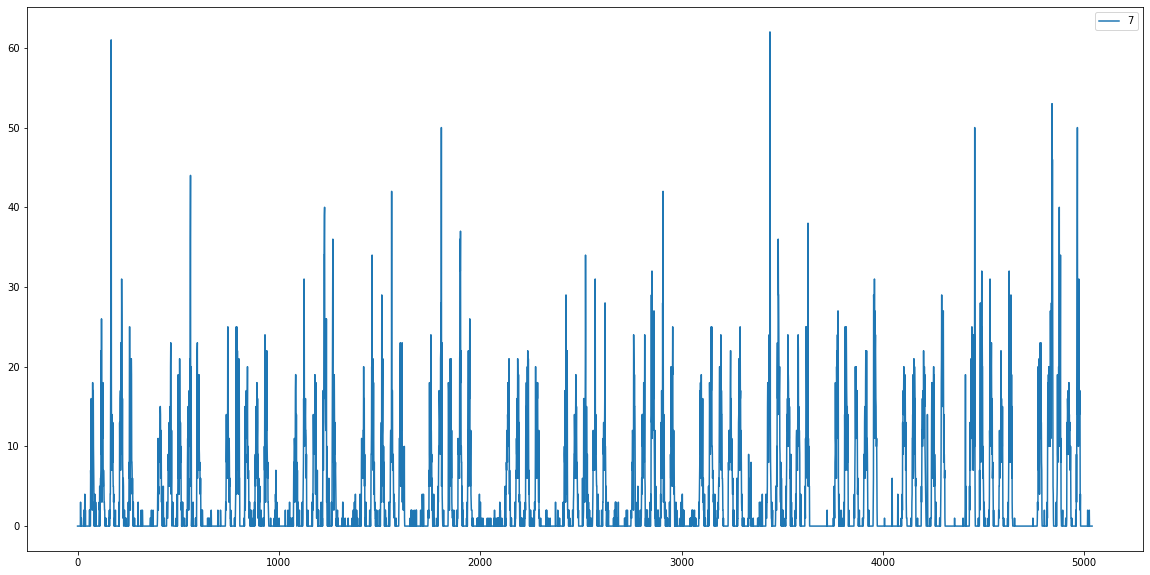

In [7]:
# plot the timeseries
print('Timeseries plot')
plt.plot(close, label = '7')
plt.legend()

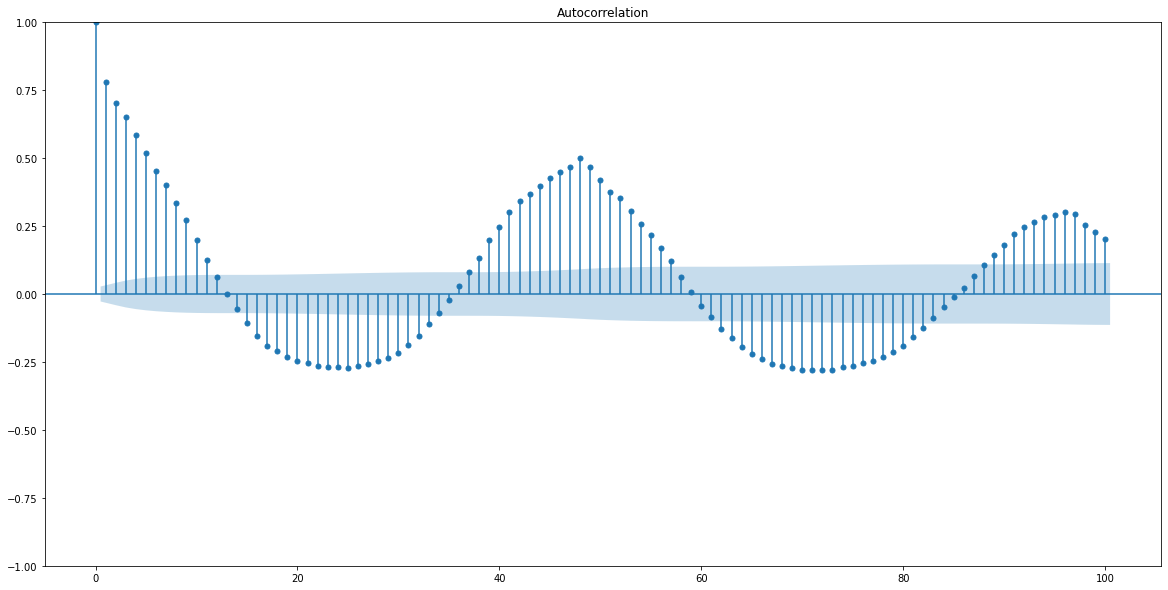

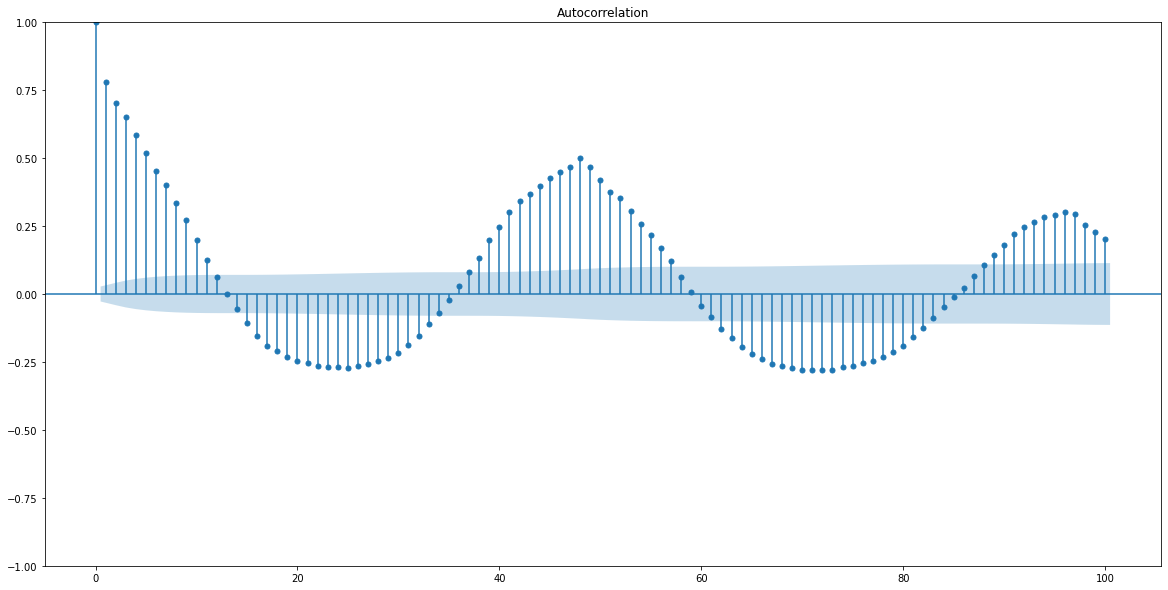

In [8]:
# acf plot
plot_acf(close, lags = 100)

c:\users\administrator\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


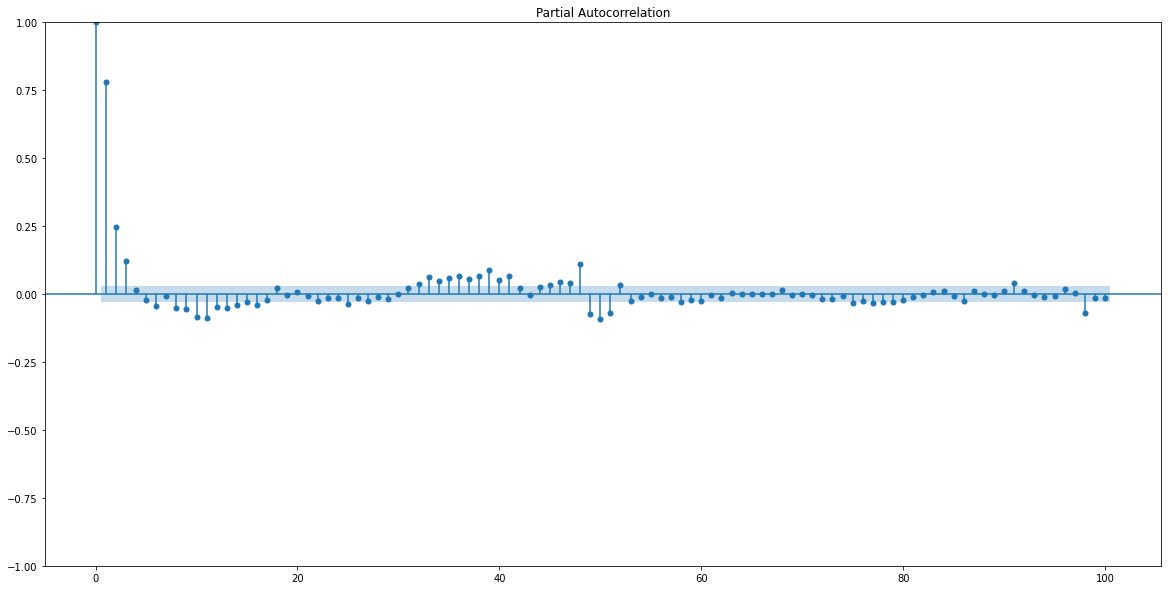

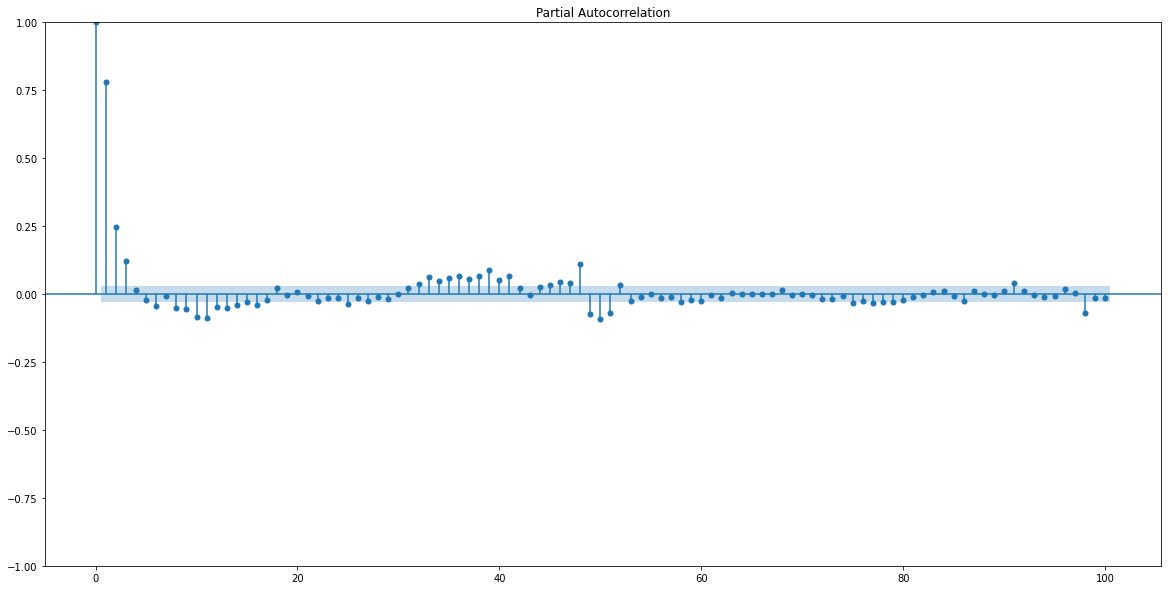

In [9]:
# pacf plot
plot_pacf(close, lags = 100)

The data is highly seasonal

In [10]:
# ADF test
result = adfuller(close)
print('ADF TEST \n')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF TEST 

ADF Statistic: -12.636841
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


From the above summary, p value = 0.00 and t value = -12.636841

At p-value < alpha = 0.05, we can reject the null hypothesis at 95% confidence level.

The series is stationary

In [11]:
# log transformation
close = close + 1 # to avoid "0"
close = np.log(close)

# Model Preparation

We first divide the dataset into train and test to find out the *suitable combination of Hyperparameters*

In [12]:
# train test split
train = close.iloc[:int(len(close)*0.8)]  #80% train
test = close.iloc[int(len(close)*0.2):]   #20% test

Function to prepare data for the LSTM

In [13]:
# function to prepare data for LSTM
def prepareData(data_lstm,lookback ,future):
    
    # convert the data_lstm into array form that is compatable with LSTM
    data_lstm = np.array(data_lstm.values).reshape(-1,1)
    
    # Lists to grab input and output sequences in the fly
    X_ = []
    Y_ = []
    
    # loop through the data
    for i in range(lookback, len(data_lstm) - future + 1):
        X_.append(data_lstm[i - lookback: i])
        Y_.append(data_lstm[i: i + future])
        
    # convert input and output sequences to array
    X_ = np.array(X_)
    Y_ = np.array(Y_)
    
    # return input and output sequences
    return(X_,Y_)

Function to train, evaluate, and save LSTM model

In [14]:
# LSTM train, evaluate and save function
def trainLstm(Xtrain,Ytrain, Xtest, Ytest, future, epoch):

    #initialize the weights
    np.random.seed(1)
    tensorflow.random.set_seed(1)

    # define model architecture
    model = Sequential()
    model.add(LSTM(20, activation='relu', return_sequences=True))
    model.add(LSTM(10, activation='relu', return_sequences=True))
    model.add(SimpleRNN(5, activation='relu'))
    model.add(Dense(future))
    model.compile(optimizer='RMSProp', loss='mse')

    # fit the model
    r = model.fit(Xtrain,Ytrain,epochs=epoch, validation_data=(Xtest, Ytest))
    
    # plotting training and validation loss
    acc = r.history['loss']
    val_acc = r.history['val_loss']
    loss = r.history['loss']
    val_loss = r.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    # making prediction
    y_p = model.predict(Xtest)
    
    predictions =[]
    # visualize and save predictions
    for i in range(future):
        plt.figure()
        plt.plot(y_p[:,i], label='Prediction', color='red',linestyle='dashed', linewidth=5)
        plt.plot(y_test[:,i], label ='Actual', color='yellow', linewidth=2)
        plt.legend()
        plt.title(f"{i + 1} step forecast")
        plt.show()
        
        # calculate performance matrices
        print(f"RMSE {i + 1} step forecast: {np.sqrt(mean_squared_error(y_p[:,i], y_test[:,i]))}")
        print(f"MAE {i + 1} step forecast: {np.sqrt(mean_absolute_error(y_p[:,i], y_test[:,i]))}")
        print(f"MAPE {i + 1} step forecast: {np.sqrt(mean_absolute_percentage_error(y_p[:,i], y_test[:,i]))}")
        
        # calculate standard deviation
        std_ = np.std(y_p[:,i])
        # calculate prediction interval
        l_limit = y_p[:,i] - 1.96*std_
        u_limit = y_p[:,i] + 1.96*std_
        # make a dataframe and append into predictions list
        predictions.append(pd.DataFrame({'Actual': y_test[:,i].flatten(), 'Pred': y_p[:,i], 'Pred Interval Lower': l_limit, 'Pred Interval Upper': u_limit}))
        
        
        
    # save model
    model.save('LSTM1.h5')
    
    # return predictions
    return predictions

Prepare data by calling the prepareData function

In [15]:
# prepare train and test data
x_train, y_train = prepareData(train,4 ,futurePeriod)
x_test, y_test = prepareData(test,4 ,futurePeriod)

Train/evaluate/save by caling the trainLstm function

In [16]:
# cast the x_train into float64
x_train = tensorflow.cast(x_train, dtype='float64')

Epoch 1/50
126/126 [==============================] - 4s 9ms/step - loss: 1.6840 - val_loss: 1.5289
Epoch 2/50
126/126 [==============================] - 1s 6ms/step - loss: 1.3141 - val_loss: 1.3156
Epoch 3/50
126/126 [==============================] - 1s 6ms/step - loss: 1.1799 - val_loss: 1.1943
Epoch 4/50
126/126 [==============================] - 1s 7ms/step - loss: 1.0396 - val_loss: 1.0444
Epoch 5/50
126/126 [==============================] - 1s 6ms/step - loss: 0.9441 - val_loss: 1.0048
Epoch 6/50
126/126 [==============================] - 1s 6ms/step - loss: 0.9122 - val_loss: 1.0105
Epoch 7/50
126/126 [==============================] - 1s 6ms/step - loss: 0.9031 - val_loss: 0.9789
Epoch 8/50
126/126 [==============================] - 1s 6ms/step - loss: 0.8961 - val_loss: 0.9799
Epoch 9/50
126/126 [==============================] - 1s 6ms/step - loss: 0.8931 - val_loss: 0.9618
Epoch 10/50
126/126 [==============================] - 1s 6ms/step - loss: 0.8935 - val_loss: 0.9629

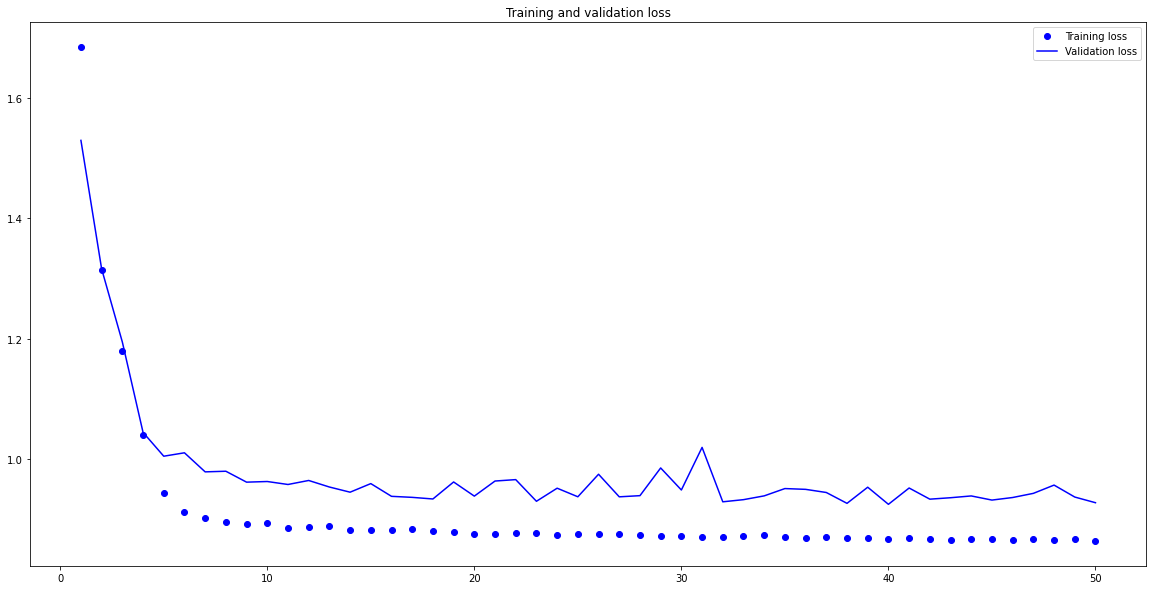

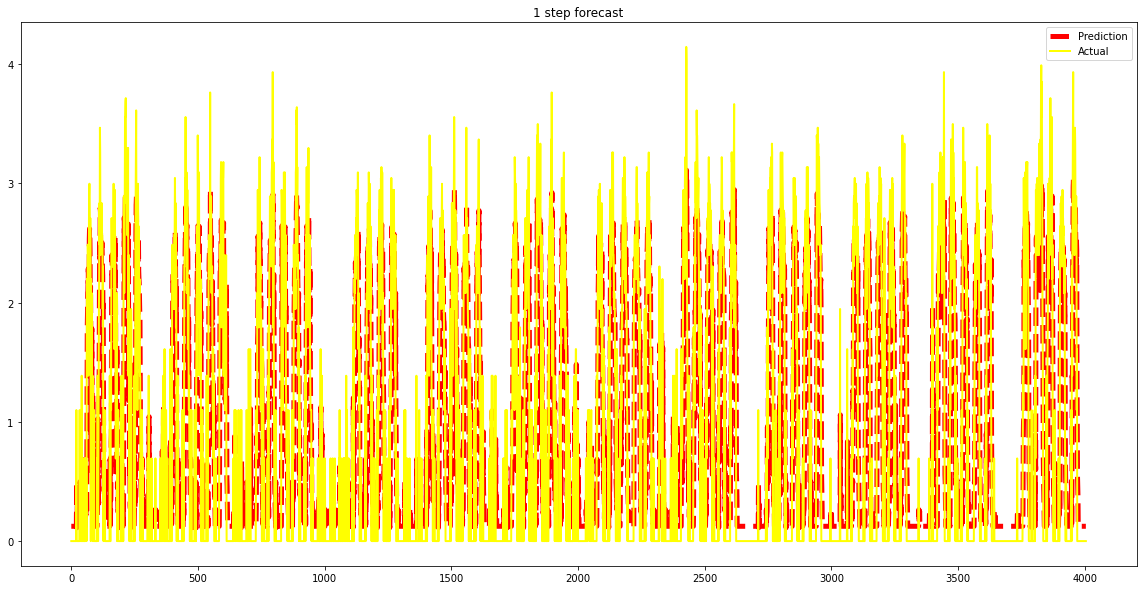

RMSE 1 step forecast: 0.527321387712366
MAE 1 step forecast: 0.6143812343679996
MAPE 1 step forecast: 1.0458834082350021


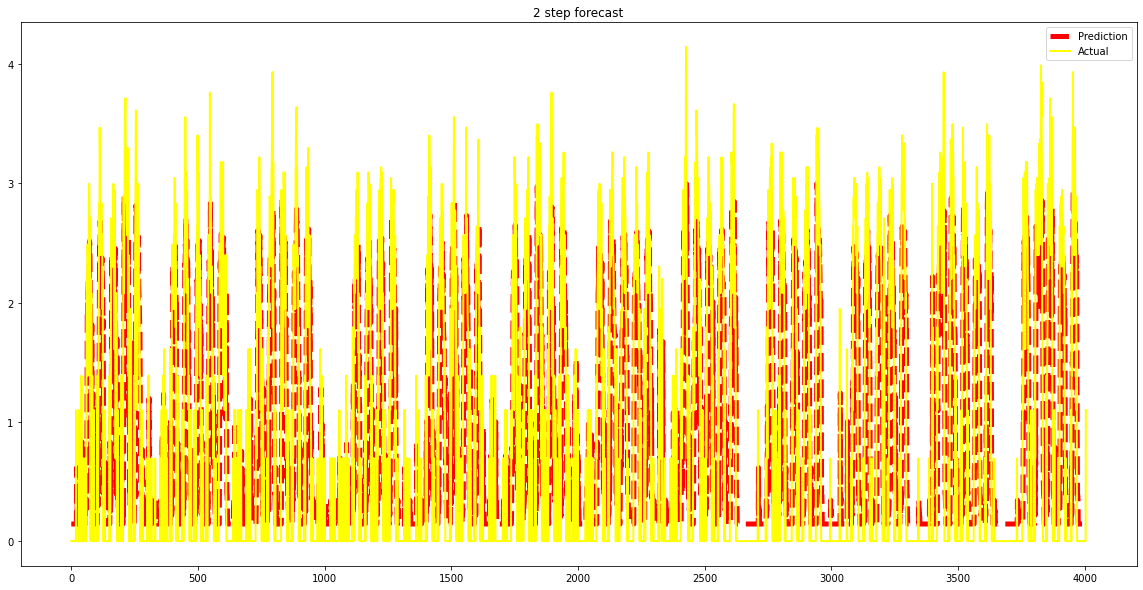

RMSE 2 step forecast: 0.6090737174932227
MAE 2 step forecast: 0.6624780041646842
MAPE 2 step forecast: 1.0562074739880438


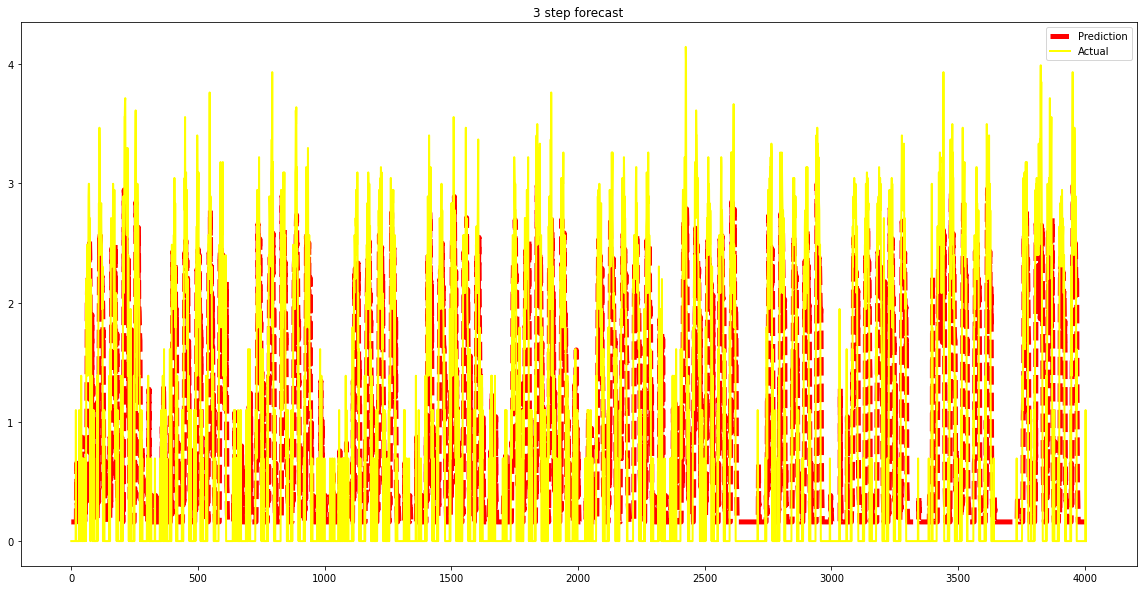

RMSE 3 step forecast: 0.6860208850264827
MAE 3 step forecast: 0.6995533954092276
MAPE 3 step forecast: 1.0794490422589997


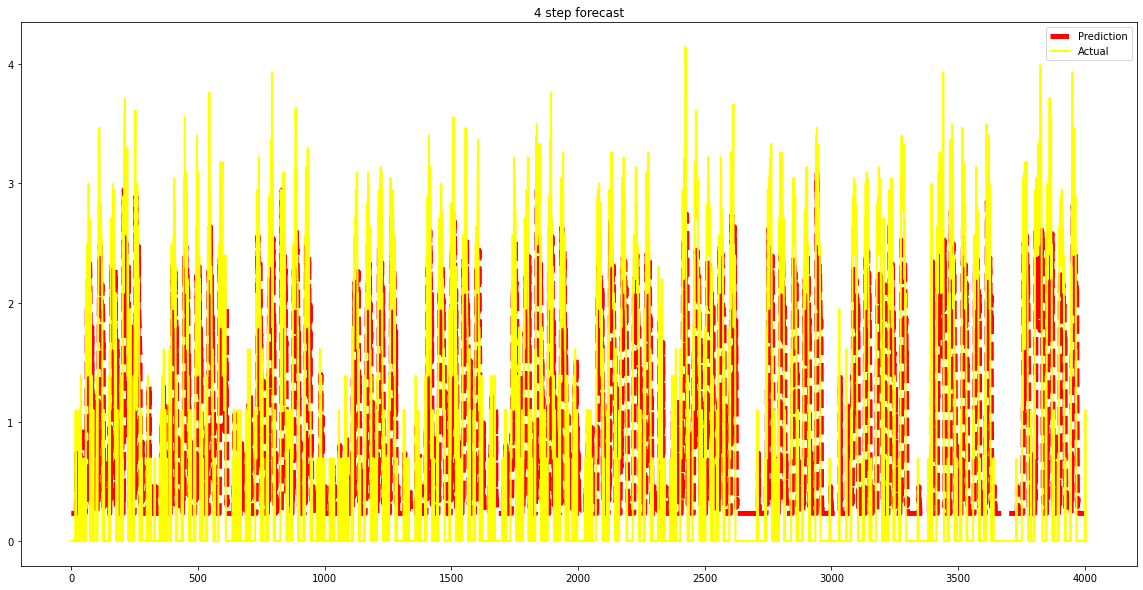

RMSE 4 step forecast: 0.7621708443479723
MAE 4 step forecast: 0.7509529762190931
MAPE 4 step forecast: 1.0728368101785954


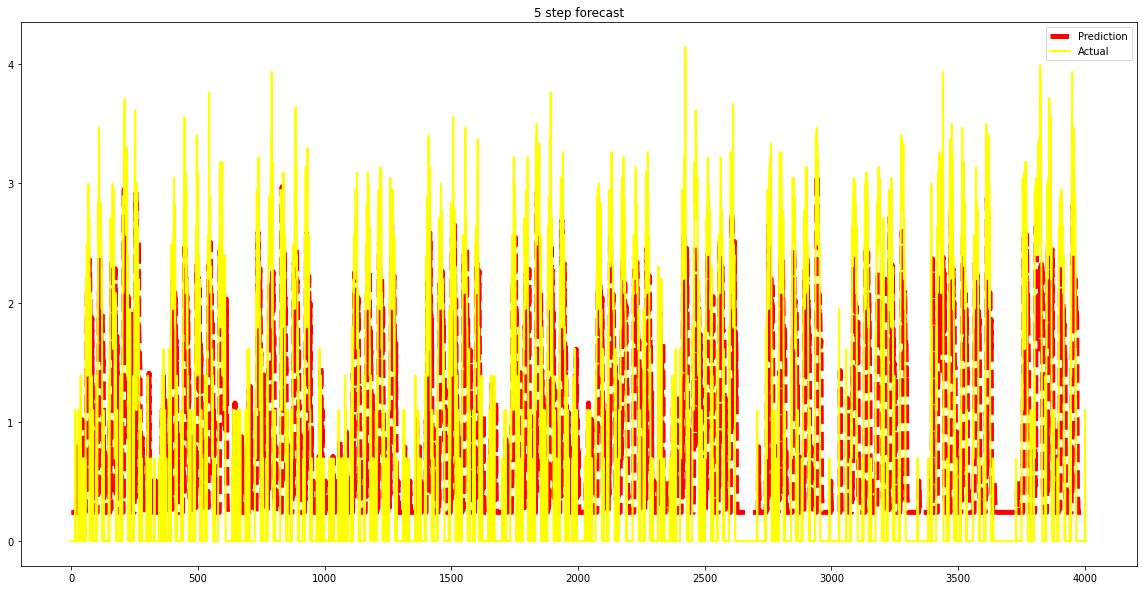

RMSE 5 step forecast: 0.8250561661314445
MAE 5 step forecast: 0.786369049970086
MAPE 5 step forecast: 1.099856942379075


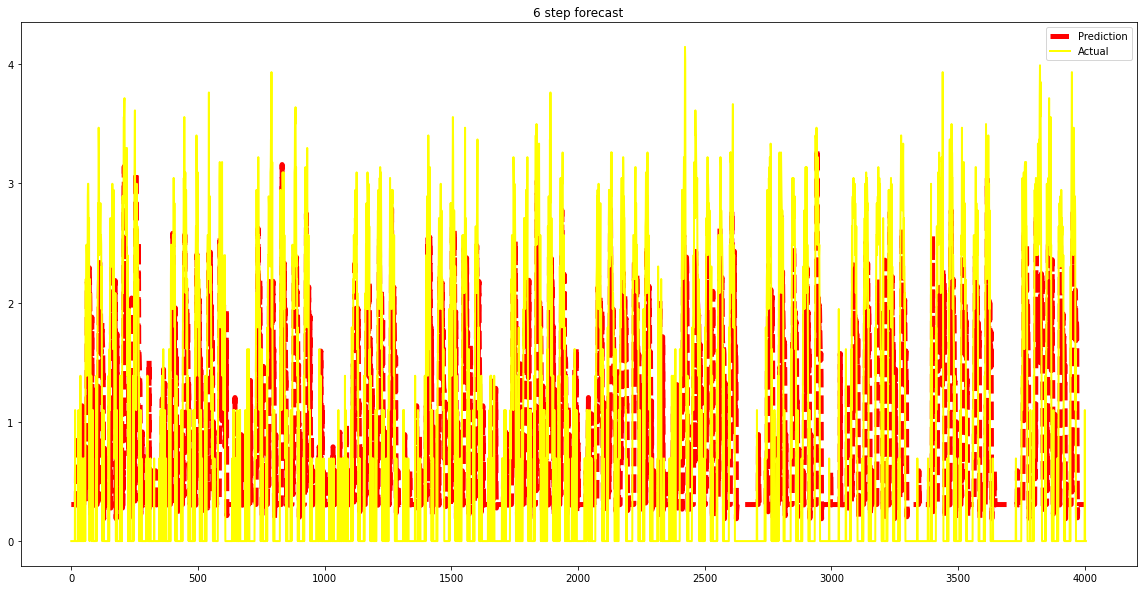

RMSE 6 step forecast: 0.8742917966420305
MAE 6 step forecast: 0.8173710298708647
MAPE 6 step forecast: 1.0992899735273216


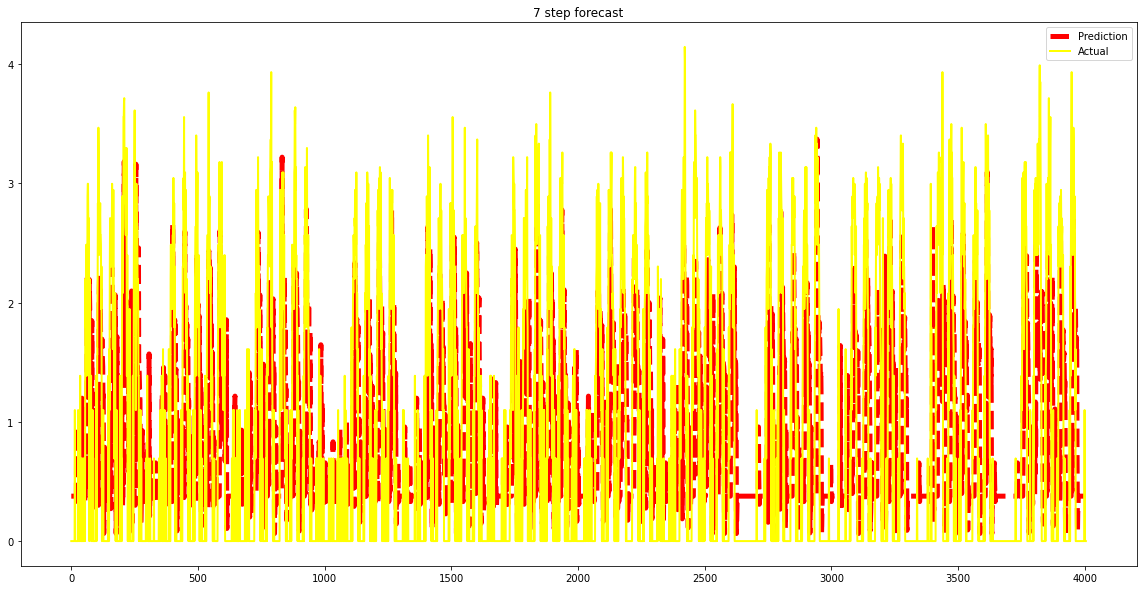

RMSE 7 step forecast: 0.9246019389362236
MAE 7 step forecast: 0.8505230232398017
MAPE 7 step forecast: 1.118652540928855


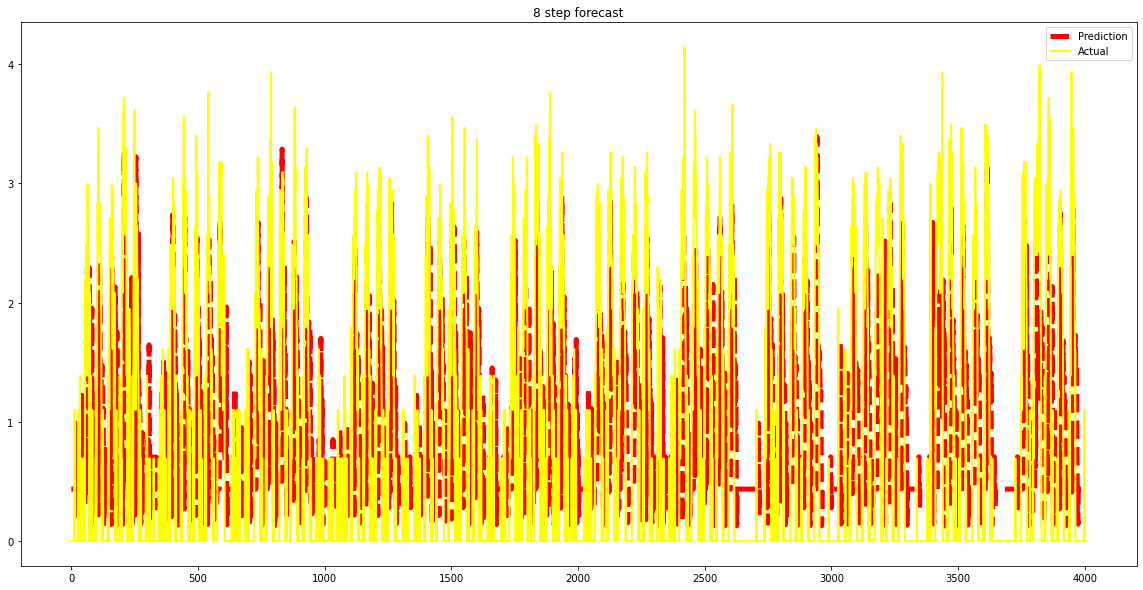

RMSE 8 step forecast: 0.9582701054879884
MAE 8 step forecast: 0.8702306219709174
MAPE 8 step forecast: 1.12829456842865


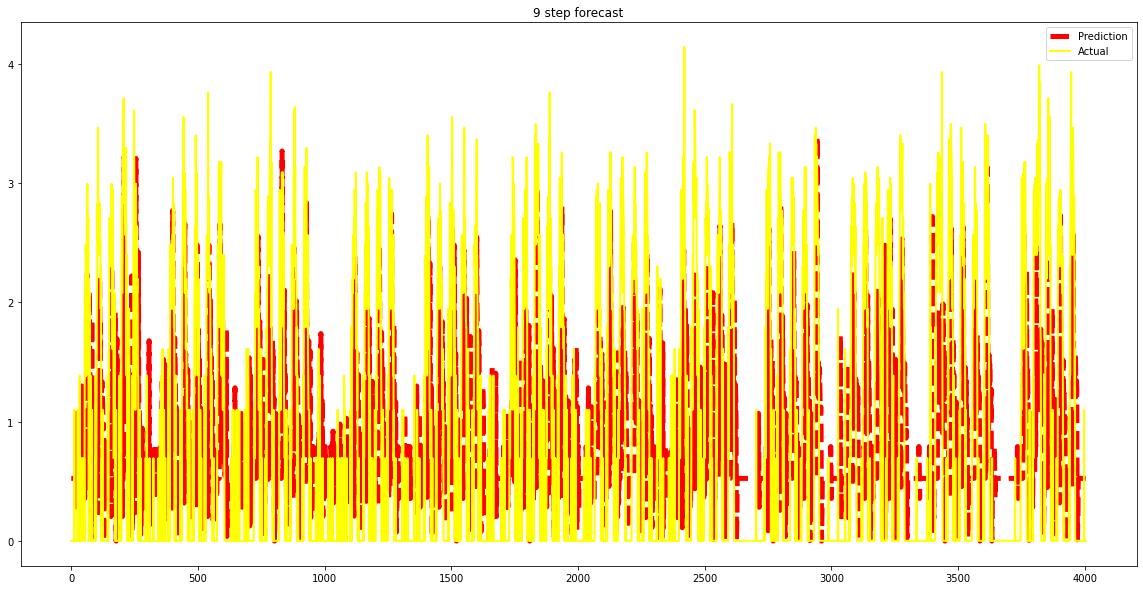

RMSE 9 step forecast: 0.9923998809150884
MAE 9 step forecast: 0.8955028735245819
MAPE 9 step forecast: 1.3154845799379515


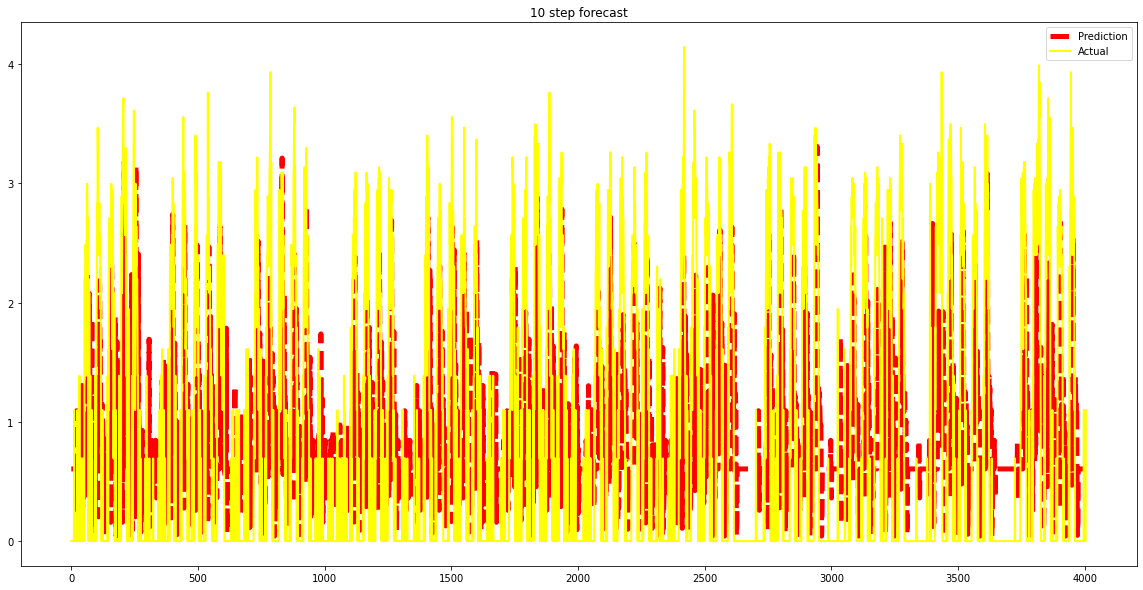

RMSE 10 step forecast: 1.0191398038757185
MAE 10 step forecast: 0.9113564983756844
MAPE 10 step forecast: 1.1233889854639654


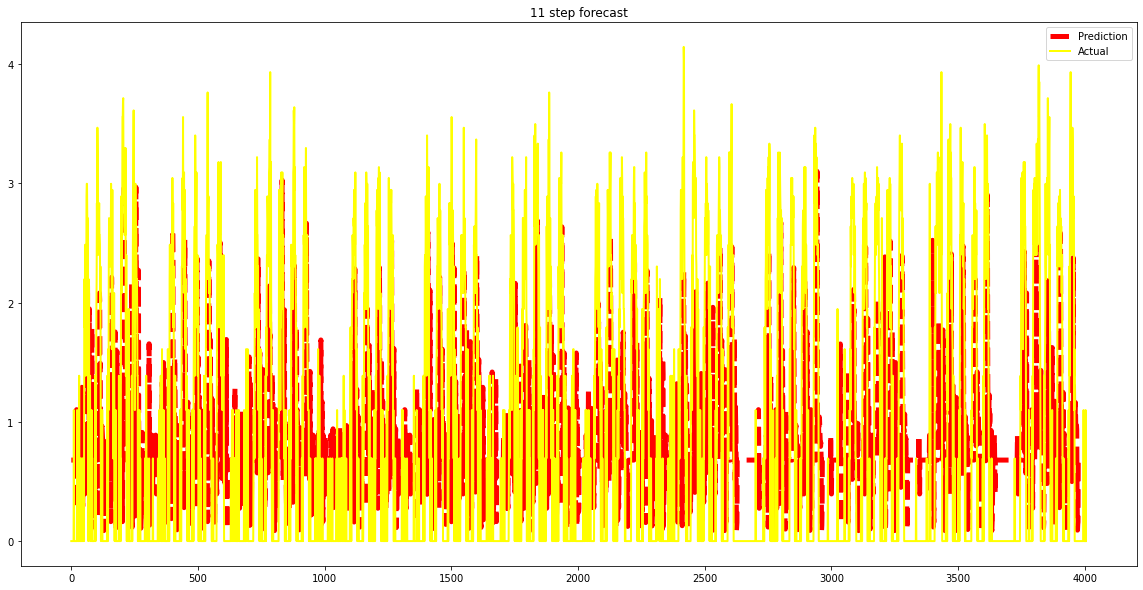

RMSE 11 step forecast: 1.0425073619682428
MAE 11 step forecast: 0.9240304168777249
MAPE 11 step forecast: 1.1212744039681881


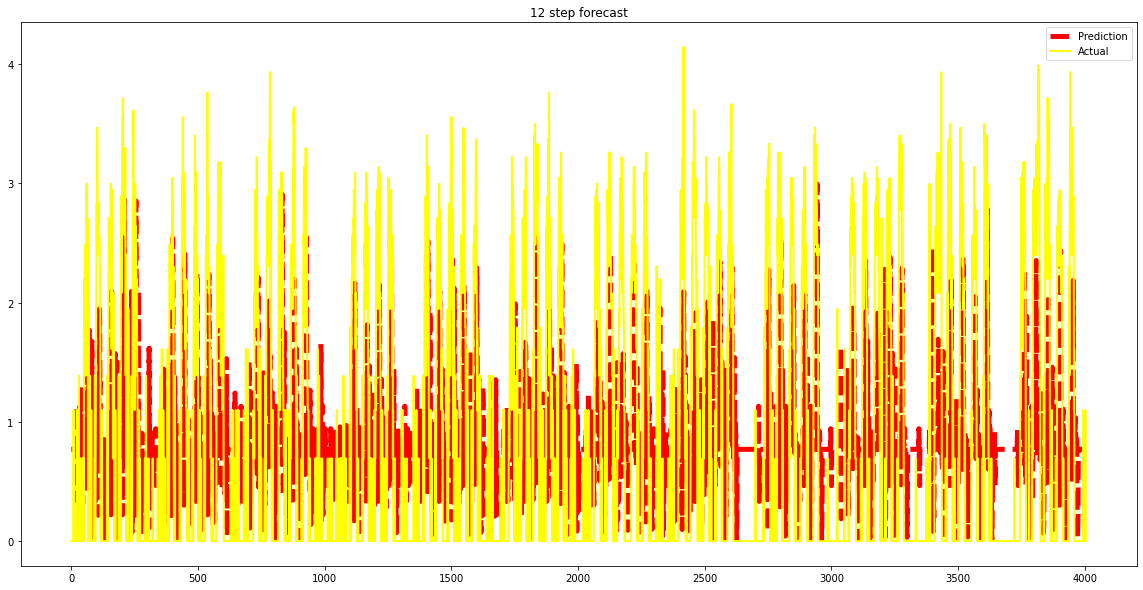

RMSE 12 step forecast: 1.0553726348726322
MAE 12 step forecast: 0.9329731376285315
MAPE 12 step forecast: 1.1295723321714572


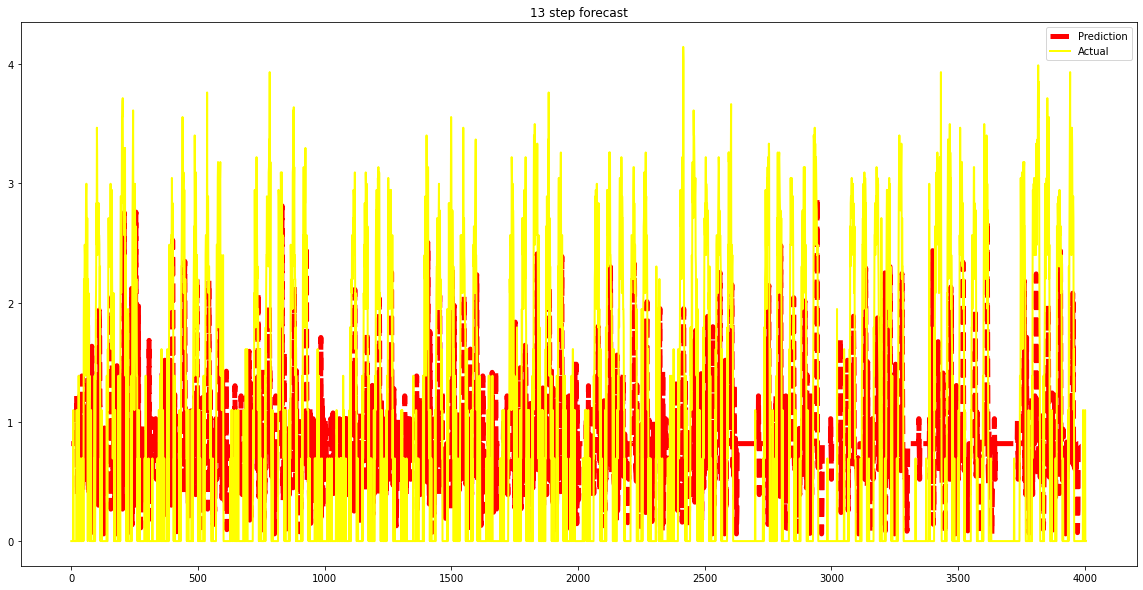

RMSE 13 step forecast: 1.0583244792372621
MAE 13 step forecast: 0.9372748869452597
MAPE 13 step forecast: 1.101993749047415


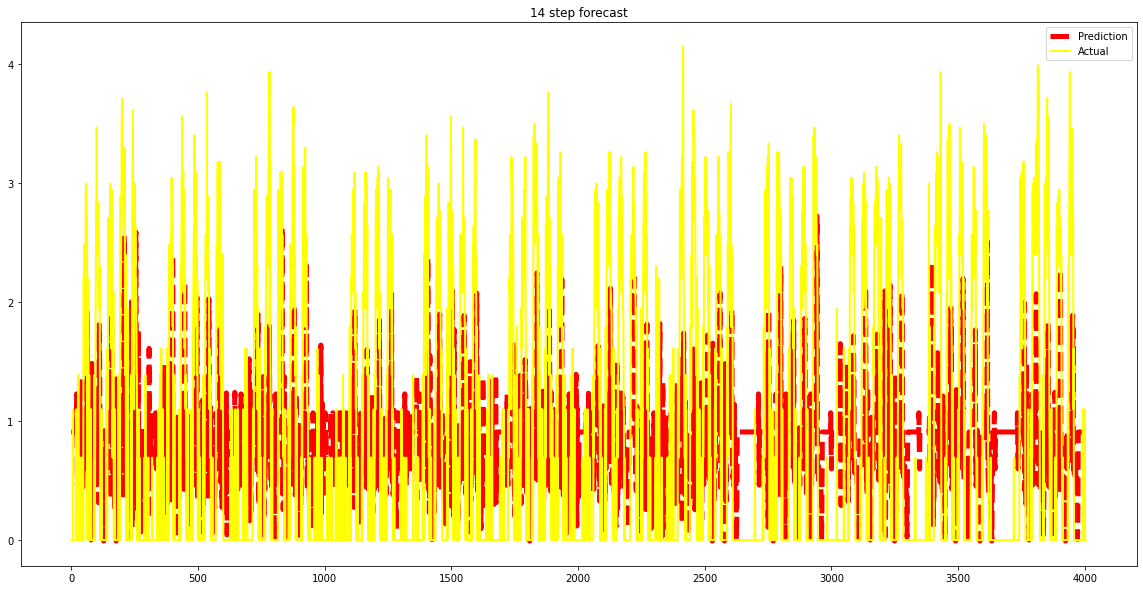

RMSE 14 step forecast: 1.0602468903142481
MAE 14 step forecast: 0.94044947992167
MAPE 14 step forecast: 1.1080628909964385


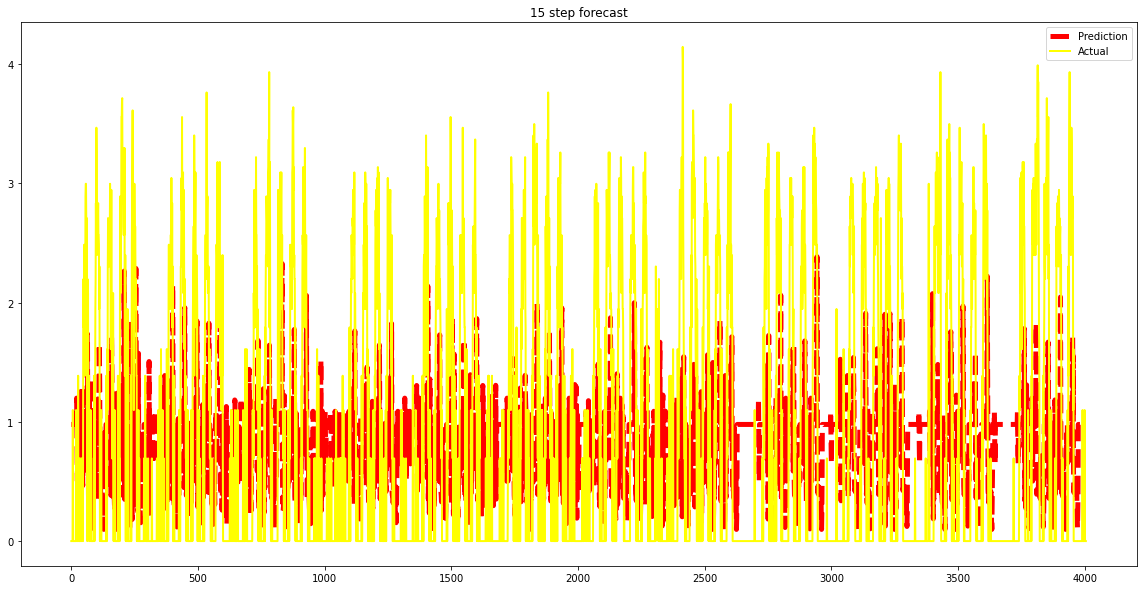

RMSE 15 step forecast: 1.0617249941799114
MAE 15 step forecast: 0.9423125427293653
MAPE 15 step forecast: 1.0981137033151278


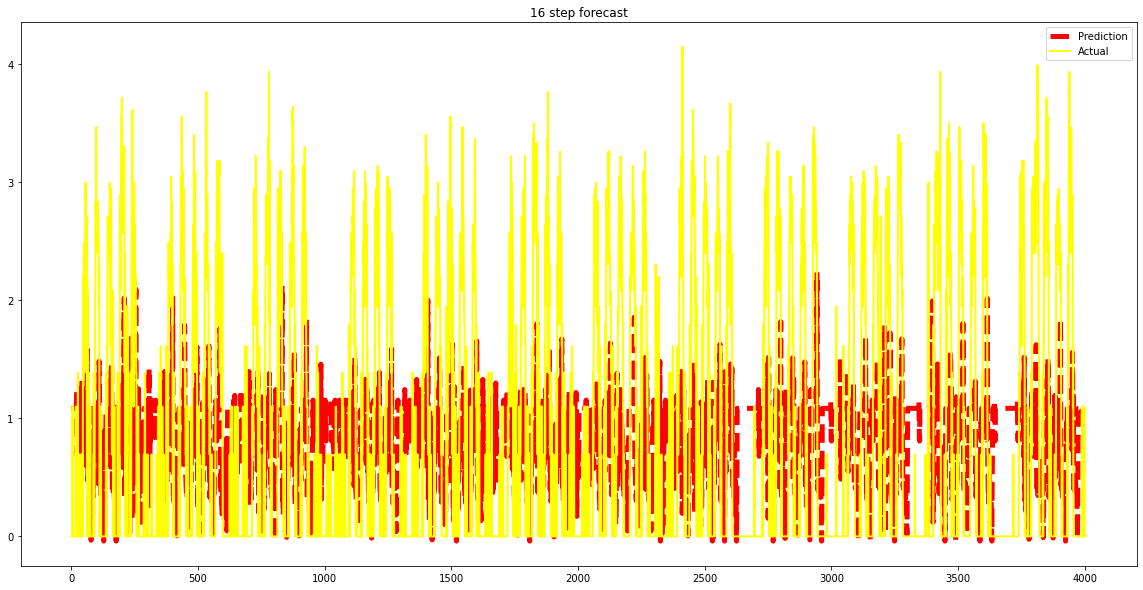

RMSE 16 step forecast: 1.0606037307184586
MAE 16 step forecast: 0.9443280968584449
MAPE 16 step forecast: 1.087475951548242


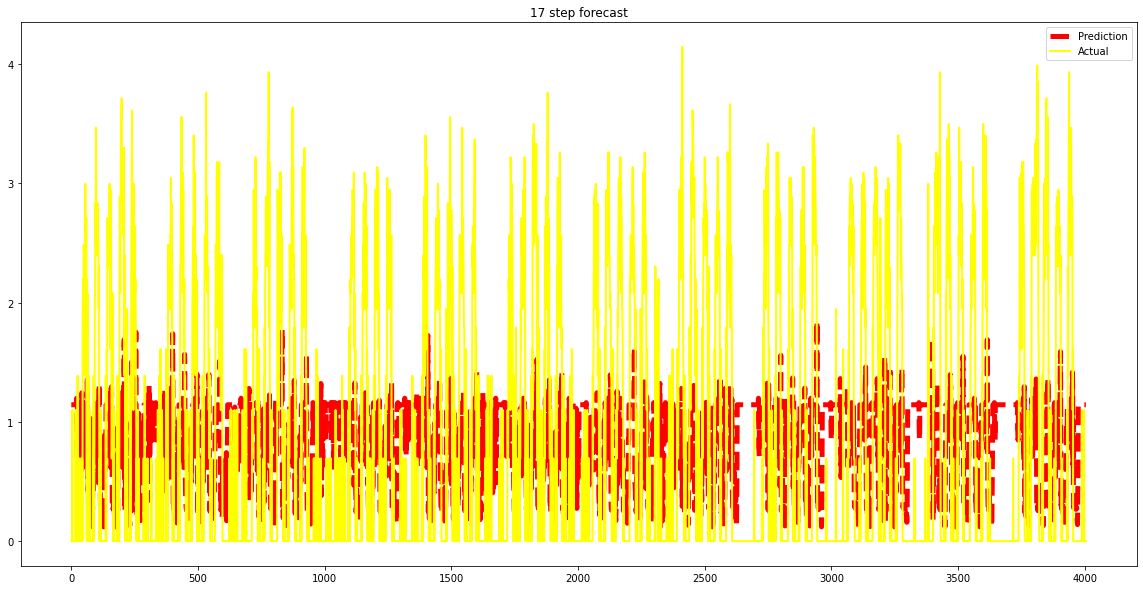

RMSE 17 step forecast: 1.0583487153495557
MAE 17 step forecast: 0.9433162008437732
MAPE 17 step forecast: 1.090987614556473


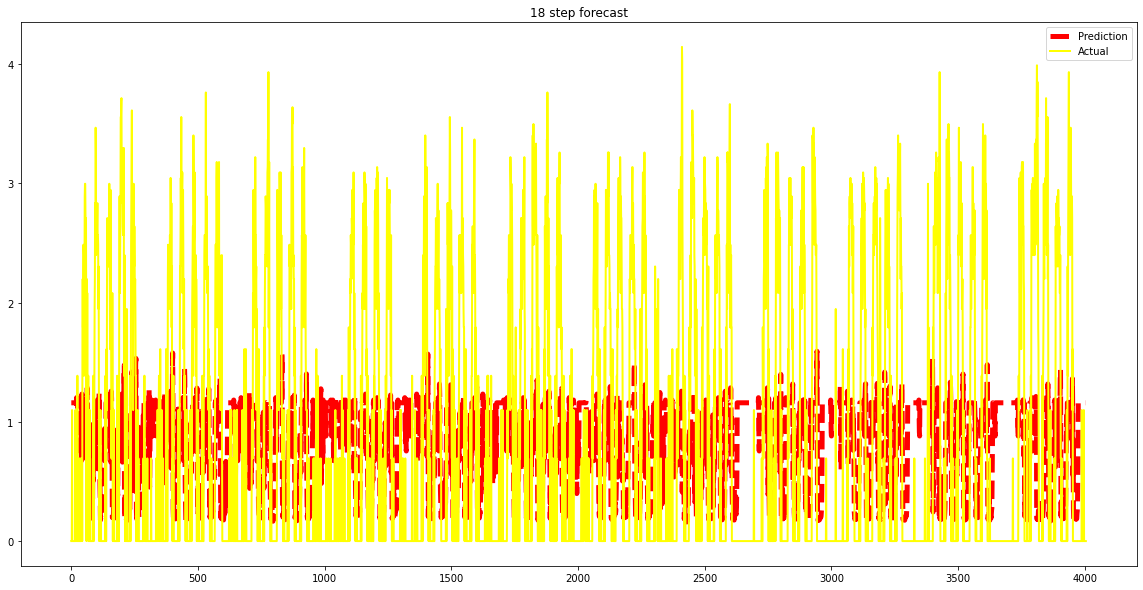

RMSE 18 step forecast: 1.051676865643906
MAE 18 step forecast: 0.9386192657411333
MAPE 18 step forecast: 1.0929760002774624


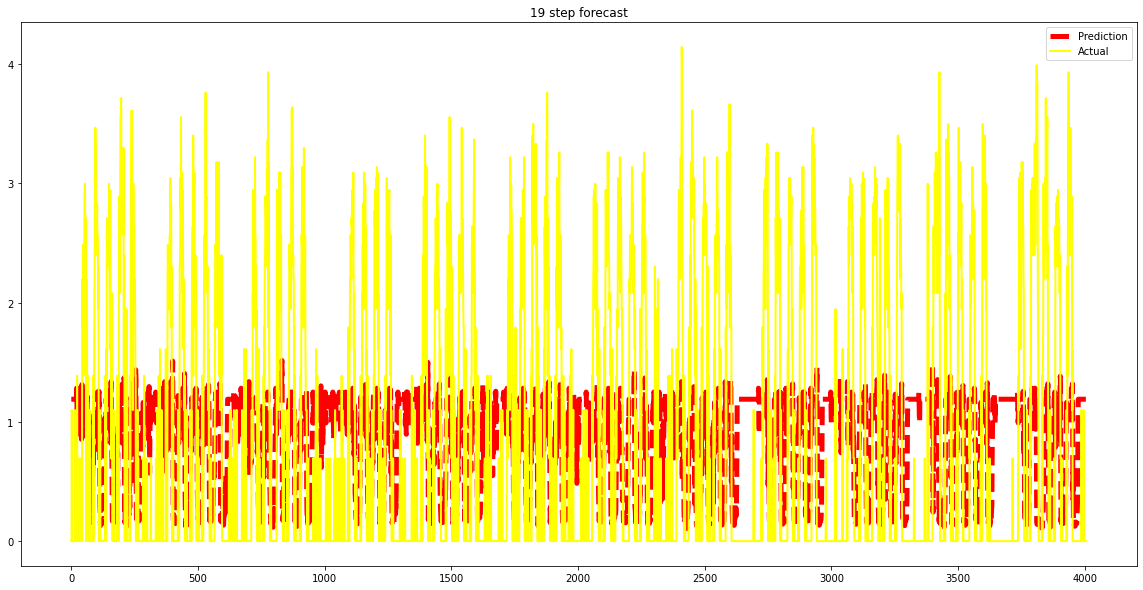

RMSE 19 step forecast: 1.0417916414993602
MAE 19 step forecast: 0.9337277096467407
MAPE 19 step forecast: 1.0888039506078908


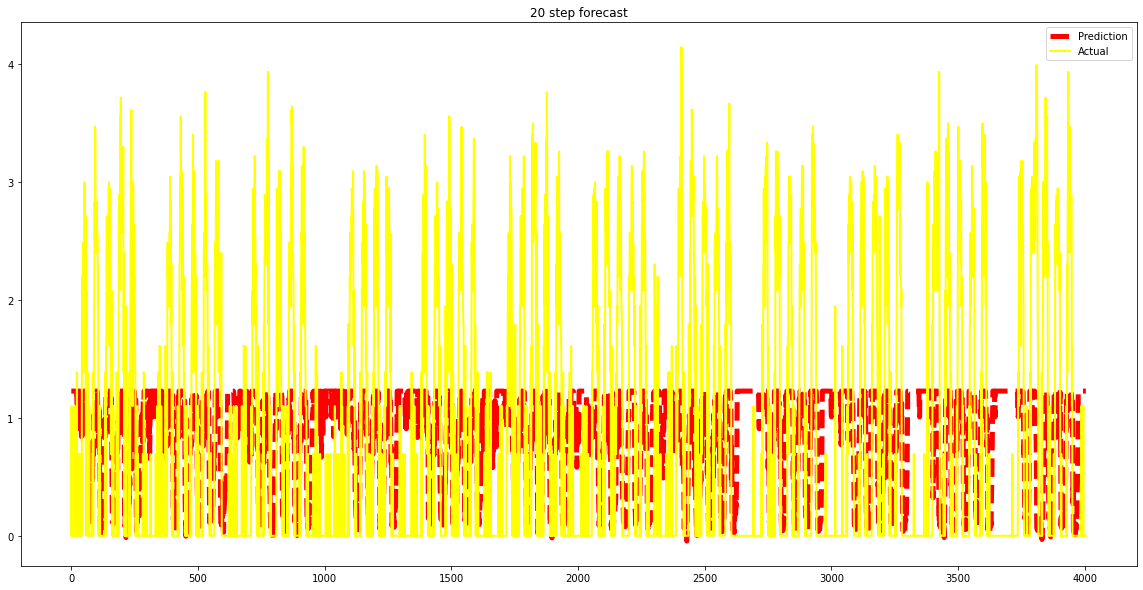

RMSE 20 step forecast: 1.0355406911116802
MAE 20 step forecast: 0.9270954022127696
MAPE 20 step forecast: 1.245208064203464


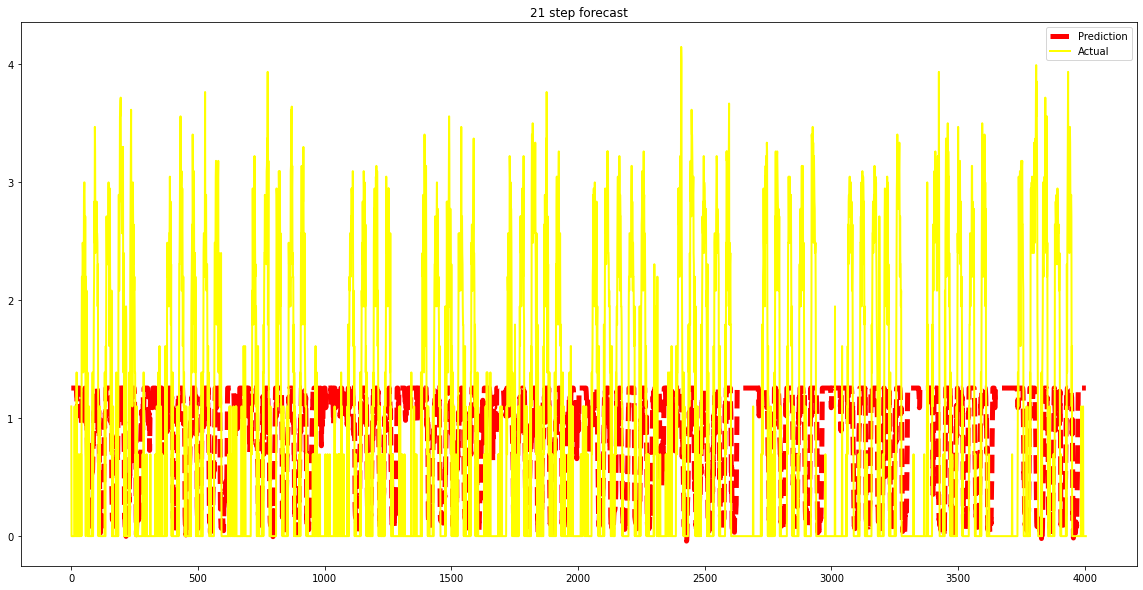

RMSE 21 step forecast: 1.030817051408896
MAE 21 step forecast: 0.9240968464735598
MAPE 21 step forecast: 1.242509791388559


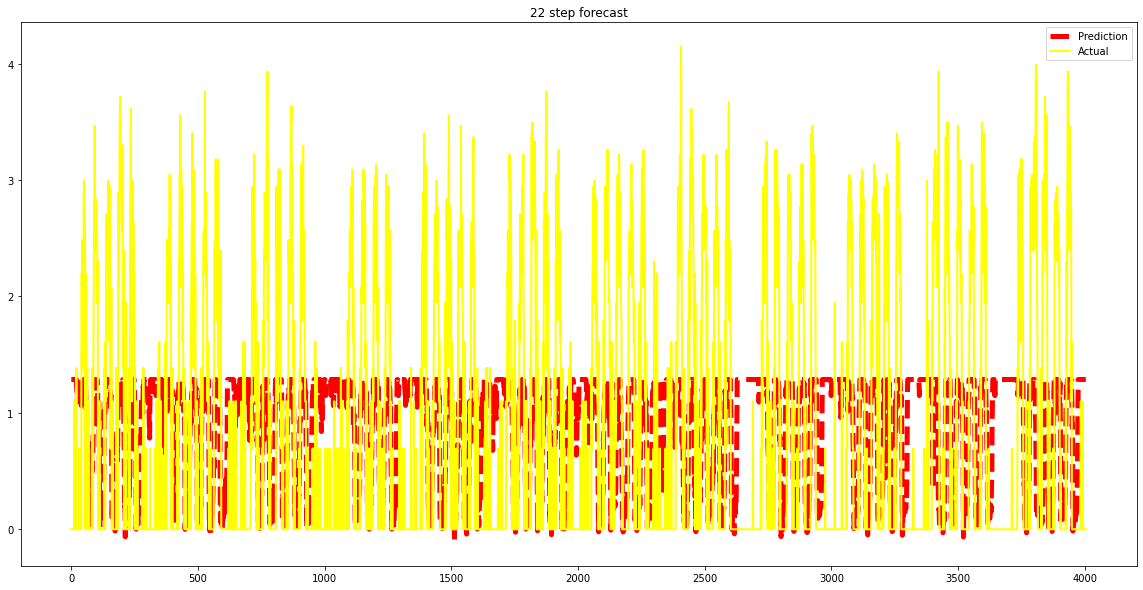

RMSE 22 step forecast: 1.0274902412531892
MAE 22 step forecast: 0.9232212223439644
MAPE 22 step forecast: 1.4021491226448588


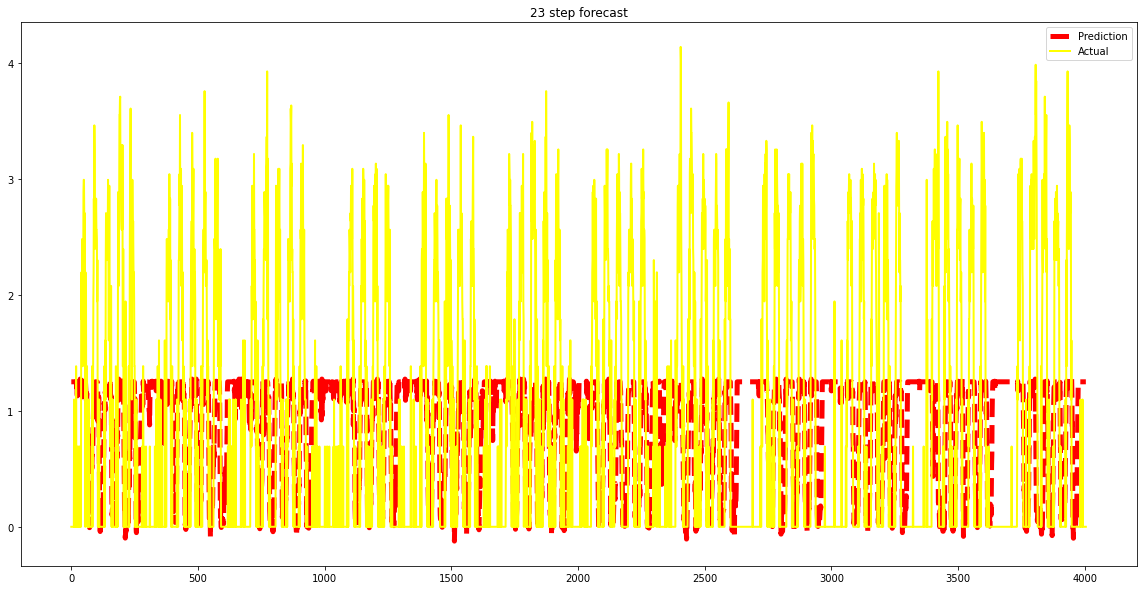

RMSE 23 step forecast: 1.0279927920691876
MAE 23 step forecast: 0.9206936277935069
MAPE 23 step forecast: 1.1998736810857327


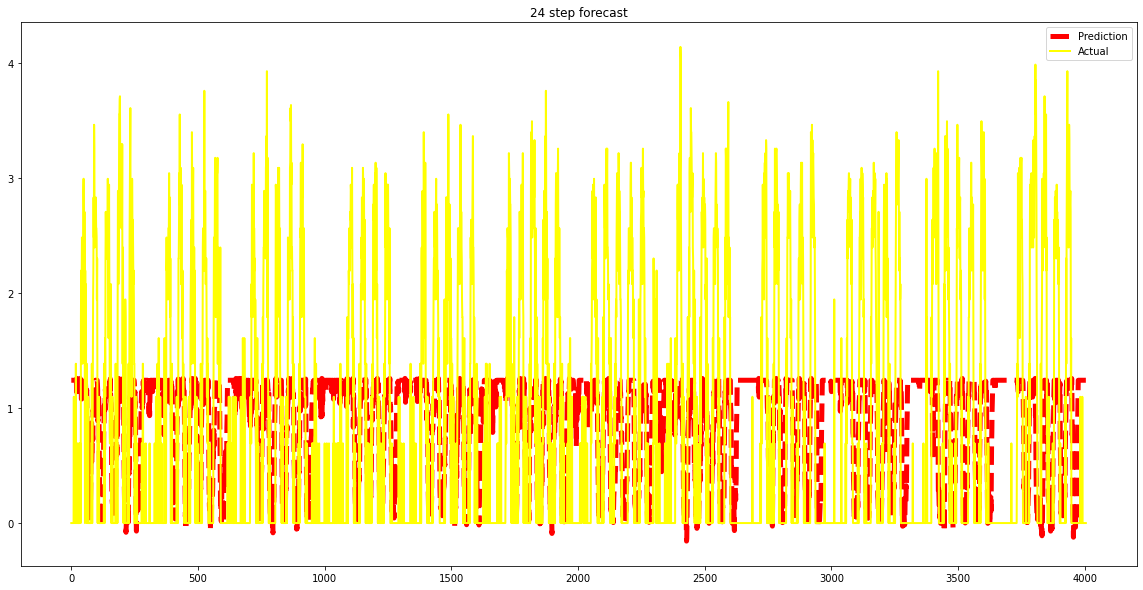

RMSE 24 step forecast: 1.032691858556744
MAE 24 step forecast: 0.9253943348818172
MAPE 24 step forecast: 1.1600391307474944


In [17]:
# train model
predictions = trainLstm(x_train, y_train, x_test, y_test, futurePeriod, 50)

In [18]:
a = 10 # prediction interval
predictions[a-1]

Actual      Pred  Pred Interval Lower  Pred Interval Upper
0     0.000000  0.604877            -0.310178             1.519931
1     0.000000  0.604877            -0.310178             1.519931
2     0.000000  0.604877            -0.310178             1.519931
3     0.000000  0.604877            -0.310178             1.519931
4     0.000000  0.604877            -0.310178             1.519931
...        ...       ...                  ...                  ...
4000  0.000000  0.604877            -0.310178             1.519931
4001  0.000000  0.604877            -0.310178             1.519931
4002  0.000000  0.604877            -0.310178             1.519931
4003  0.000000  0.604877            -0.310178             1.519931
4004  1.098612  0.604877            -0.310178             1.519931

[4005 rows x 4 columns]

In [19]:
a = 12 # prediction interval
predictions[a-1]

Actual      Pred  Pred Interval Lower  Pred Interval Upper
0     0.000000  0.769365             0.030727             1.508003
1     0.000000  0.769365             0.030727             1.508003
2     0.000000  0.769365             0.030727             1.508003
3     0.000000  0.769365             0.030727             1.508003
4     0.000000  0.769365             0.030727             1.508003
...        ...       ...                  ...                  ...
4000  0.000000  0.769365             0.030727             1.508003
4001  0.000000  0.769365             0.030727             1.508003
4002  1.098612  0.769365             0.030727             1.508003
4003  0.000000  0.769365             0.030727             1.508003
4004  0.000000  0.769365             0.030727             1.508003

[4005 rows x 4 columns]